Data Collection with CCXT

In [1]:
import ccxt
import pandas as pd

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

# Initialize the exchange
exchange = ccxt.binance()

symbol = 'BTC/USDT'
timeframe = '1h'
since = exchange.parse8601('2021-01-01T00:00:00Z')
now = exchange.milliseconds()

all_candles = []

while since < now:
    candles = exchange.fetch_ohlcv(symbol, timeframe, since)
    if len(candles) == 0:
        break
    since = candles[-1][0] + 1  # start the next fetch from the end of the last one
    all_candles += candles

# Convert to DataFrame
df = pd.DataFrame(all_candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')

# Create a copy with the closing price for forecasting
data = df[['date', 'close', 'volume', 'high', 'low']].copy()
data.rename(columns={'date': 'ds', 'close': 'y', 'volume': 'volume', 'high': 'high', 'low': 'low'}, inplace=True)

print(data.head())
# print(data.describe())


                   ds         y       volume      high       low
0 2021-01-01 00:00:00  28995.13  2311.811445  29031.34  28690.17
1 2021-01-01 01:00:00  29409.99  5403.068471  29470.00  28960.35
2 2021-01-01 02:00:00  29194.65  2384.231560  29465.26  29120.03
3 2021-01-01 03:00:00  29278.40  1461.345077  29367.00  29150.02
4 2021-01-01 04:00:00  29220.31  2038.046803  29395.00  29029.40


Hyperparameter tuning for Prophet model using Grid Search

In [2]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import itertools
import numpy as np

# Define parameter grid
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
    'yearly_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'daily_seasonality': [True, False]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Placeholder for best params and RMSE
best_params = {}
lowest_rmse = float('inf')

# Function to train and evaluate a model
def train_evaluate_model(params, data):
    model = Prophet(**params)
    model.fit(data)
    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)
    rmse = np.sqrt(mean_squared_error(data['y'], forecast[:len(data)]['yhat']))
    return rmse

# Grid search loop
for params in all_params:
    rmse = train_evaluate_model(params, data)
    if rmse < lowest_rmse:
        best_params = params
        lowest_rmse = rmse

print(f"Best parameters: {best_params}")
print(f"Lowest RMSE: {lowest_rmse}")

d:\Developer\2023\Python\jupyter-notebooks\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
08:59:21 - cmdstanpy - INFO - Chain [1] start processing
08:59:37 - cmdstanpy - INFO - Chain [1] done processing
08:59:41 - cmdstanpy - INFO - Chain [1] start processing
08:59:54 - cmdstanpy - INFO - Chain [1] done processing
08:59:59 - cmdstanpy - INFO - Chain [1] start processing
09:00:12 - cmdstanpy - INFO - Chain [1] done processing
09:00:16 - cmdstanpy - INFO - Chain [1] start processing
09:00:34 - cmdstanpy - INFO - Chain [1] done processing
09:00:37 - cmdstanpy - INFO - Chain [1] start processing
09:00:55 - cmdstanpy - INFO - Chain [1] done processing
09:00:58 - cmdstanpy - INFO - Chain [1] start processing
09:01:15 - cmdstanpy - INFO - Chain [1] done processing
09:01:18 - cmdstanpy - INFO - Chain [1] start proc

Best parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
Lowest RMSE: 2056.9813421958816


Plot the historical Bitcoin prices

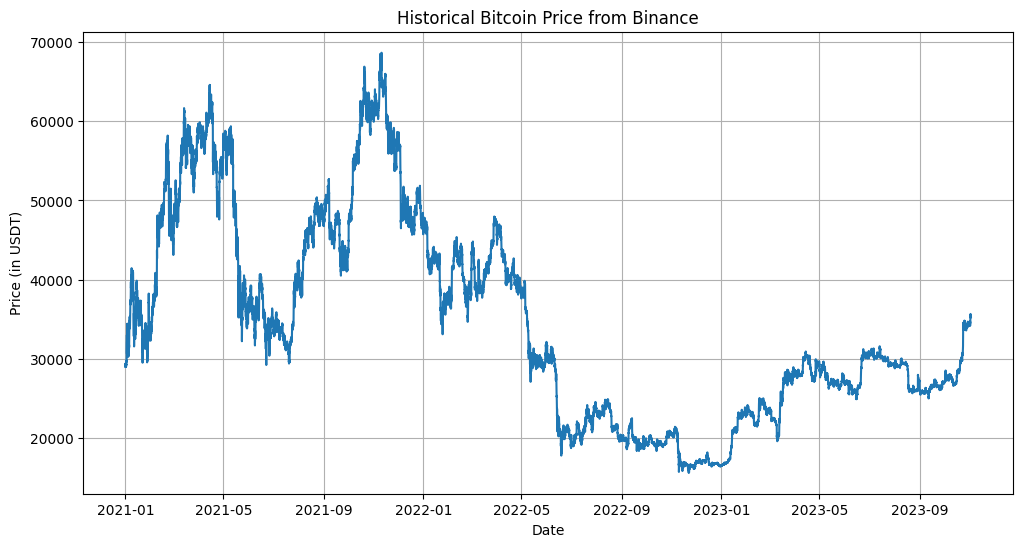

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['ds'], data['y'])
plt.title('Historical Bitcoin Price from Binance')
plt.xlabel('Date')
plt.ylabel('Price (in USDT)')
plt.grid(True)
plt.show()

Add additional regressors/features & Clean Data

In [4]:
import talib

# Adding short term moving averages
data['ma5'] = data['y'].rolling(window=5).mean()
data['ma10'] = data['y'].rolling(window=10).mean()
data['rsi'] = talib.RSI(data['y'].values, timeperiod=16)
data['obv'] = talib.OBV(data['y'].values, data['volume'].values)
data['macd'], data['signal'], _ = talib.MACD(data['y'].values, fastperiod=12, slowperiod=26, signalperiod=9)

# Stochastic Oscillator
data['k'], data['d'] = talib.STOCH(data['high'].values, data['low'].values, data['y'].values, fastk_period=14, slowk_period=3, slowd_period=3)

# ATR (Average True Range)
data['atr'] = talib.ATR(data['high'].values, data['low'].values, data['y'].values, timeperiod=14)

# Bollinger Bands
data['upper'], data['middle'], data['lower'] = talib.BBANDS(data['y'].values, timeperiod=20)

# Remove NaN rows created due to rolling operations and indicators
data.dropna(inplace=True)

Fit and Train the Prophet model with features/regressors

In [5]:
from prophet import Prophet

# Initialize the Prophet model
model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05
)

# Add regressors for the model
model.add_regressor('rsi')
model.add_regressor('obv')
model.add_regressor('ma5')
model.add_regressor('ma10')
model.add_regressor('macd')
model.add_regressor('signal')
model.add_regressor('k')
model.add_regressor('d')
model.add_regressor('atr')
model.add_regressor('upper')
model.add_regressor('middle')
model.add_regressor('lower')

# Train the model with the data
model.fit(data)

09:26:11 - cmdstanpy - INFO - Chain [1] start processing
09:26:25 - cmdstanpy - INFO - Chain [1] done processing


Create future date data for which we want to predict the Bitcoin prices and then generate forecasts. Also demonstrate Forecasting with the Regressor/Feature

In [6]:

# Initialize an empty dictionary to hold the forecasts for each indicator
forecasts = {}

# List of all TA indicators
indicators = ['ma5', 'ma10', 'rsi', 'obv', 'macd', 'signal', 'k', 'd', 'atr', 'upper', 'middle', 'lower']

# Loop through each indicator to forecast it
for indicator in indicators:
    # Prepare DataFrame for Prophet
    ind_df = data[['ds', indicator]].dropna()
    ind_df.rename(columns={indicator: 'y'}, inplace=True)
    
    # Initialize and fit Prophet model
    ind_model = Prophet()
    ind_model.fit(ind_df)
    
    # Make future DataFrame and forecast
    ind_future = ind_model.make_future_dataframe(periods=365)
    ind_forecast = ind_model.predict(ind_future)
    
    # Store the forecast in the dictionary
    forecasts[indicator] = ind_forecast['yhat']

# Prepare the main future DataFrame
main_future = model.make_future_dataframe(periods=365)

# Add the forecasted values of each indicator to the main future DataFrame
for indicator in indicators:
    main_future[indicator] = forecasts[indicator]

# Now you can proceed with the main Prophet model's prediction
main_forecast = model.predict(main_future)

09:26:27 - cmdstanpy - INFO - Chain [1] start processing
09:27:03 - cmdstanpy - INFO - Chain [1] done processing
09:27:08 - cmdstanpy - INFO - Chain [1] start processing
09:27:43 - cmdstanpy - INFO - Chain [1] done processing
09:27:48 - cmdstanpy - INFO - Chain [1] start processing
09:27:56 - cmdstanpy - INFO - Chain [1] done processing
09:28:02 - cmdstanpy - INFO - Chain [1] start processing
09:28:35 - cmdstanpy - INFO - Chain [1] done processing
09:28:40 - cmdstanpy - INFO - Chain [1] start processing
09:28:47 - cmdstanpy - INFO - Chain [1] done processing
09:28:52 - cmdstanpy - INFO - Chain [1] start processing
09:29:01 - cmdstanpy - INFO - Chain [1] done processing
09:29:06 - cmdstanpy - INFO - Chain [1] start processing
09:29:10 - cmdstanpy - INFO - Chain [1] done processing
09:29:15 - cmdstanpy - INFO - Chain [1] start processing
09:29:18 - cmdstanpy - INFO - Chain [1] done processing
09:29:23 - cmdstanpy - INFO - Chain [1] start processing
09:29:51 - cmdstanpy - INFO - Chain [1]

Predict the price for the next day

In [7]:
# Predict Bitcoin price for the next day
future_day = model.make_future_dataframe(periods=1, freq='D', include_history=False)

# Use the first forecasted value for each TA indicator for the next day
for indicator in indicators:
    next_day_value = forecasts[indicator].iloc[0]
    future_day[indicator] = next_day_value

# Generate the one-day-ahead forecast
forecast_day = model.predict(future_day)
next_day_price = forecast_day['yhat'].values[0]
print(f"Predicted Bitcoin price for the next day: ${next_day_price:.2f}")

Predicted Bitcoin price for the next day: $34959.54


Rolling Window Back-Testing

In [8]:
# Define window sizes
training_window_size = 80
testing_window_size = 10

def train_and_forecast(train_data, testing_window_size):
    # Initialize and configure the Prophet model with best parameters
    model = Prophet(**best_params)
    
    # Add the regressors
    for indicator in indicators:
        model.add_regressor(indicator)
    
    model.fit(train_data)
    
    future = model.make_future_dataframe(periods=testing_window_size)
    # Ensure the future dataframe has the regressors for the testing window
    for indicator in indicators:
        future[indicator] = pd.concat([train_data[indicator], test_data[indicator]], ignore_index=True)
    
    forecast = model.predict(future)
    
    return forecast.tail(testing_window_size)

# Initialize the starting indices for the rolling window
start_idx = 0
end_idx = training_window_size + testing_window_size

forecasts = []
actuals = []

# Roll the window through the dataset
while end_idx <= len(data):
    train_data = data.iloc[start_idx:end_idx-testing_window_size]
    test_data = data.iloc[end_idx-testing_window_size:end_idx]
    
    # # Print the head of train_data and test_data
    # print("Train Data:")
    # print(train_data.head())
    # print("\nTest Data:")
    # print(test_data.head())
    # print("---------------------------------------------------")
    
    forecast = train_and_forecast(train_data, testing_window_size)
    
    forecasts.append(forecast)
    actuals.append(test_data)
    
    start_idx += testing_window_size
    end_idx += testing_window_size

09:31:31 - cmdstanpy - INFO - Chain [1] start processing
09:31:36 - cmdstanpy - INFO - Chain [1] done processing
09:31:37 - cmdstanpy - INFO - Chain [1] start processing
09:31:44 - cmdstanpy - INFO - Chain [1] done processing
09:31:44 - cmdstanpy - INFO - Chain [1] start processing
09:31:51 - cmdstanpy - INFO - Chain [1] done processing
09:31:51 - cmdstanpy - INFO - Chain [1] start processing
09:31:56 - cmdstanpy - INFO - Chain [1] done processing
09:31:56 - cmdstanpy - INFO - Chain [1] start processing
09:31:58 - cmdstanpy - INFO - Chain [1] done processing
09:31:59 - cmdstanpy - INFO - Chain [1] start processing
09:32:05 - cmdstanpy - INFO - Chain [1] done processing
09:32:05 - cmdstanpy - INFO - Chain [1] start processing
09:32:13 - cmdstanpy - INFO - Chain [1] done processing
09:32:14 - cmdstanpy - INFO - Chain [1] start processing
09:32:21 - cmdstanpy - INFO - Chain [1] done processing
09:32:21 - cmdstanpy - INFO - Chain [1] start processing
09:32:27 - cmdstanpy - INFO - Chain [1]

KeyboardInterrupt: 

Evaluation

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

rmses = []

for forecast, actual in zip(forecasts, actuals):
    rmse = np.sqrt(mean_squared_error(actual['y'], forecast['yhat']))
    rmses.append(rmse)

average_rmse = np.mean(rmses)

print(f"Average RMSE over all rolling test windows: {average_rmse:.2f}")

Visualize & Analyze

In [ ]:
import plotly.graph_objects as go

for forecast, actual in zip(forecasts, actuals):
    fig = go.Figure()

    # Add actual data trace
    fig.add_trace(go.Scatter(x=actual['ds'], y=actual['y'], mode='lines', name='Actual'))

    # Add forecasted data trace
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast'))

    # Add confidence interval
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill=None, mode='lines', line=dict(color='gray'), name='Upper Bound'))
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='lines', line=dict(color='gray'), name='Lower Bound'))

    # Layout settings
    fig.update_layout(title='Actual vs. Forecasted Bitcoin Prices', xaxis_title='Date', yaxis_title='Price', hovermode='x unified')
    
    fig.show()

Visualize the predicted prices

In [ ]:
fig1 = model.plot(main_forecast)

 Break down the forecast into its various components

In [ ]:
fig2 = model.plot_components(main_forecast)

Setup & Perform Cross-Validation

In [ ]:
from prophet.diagnostics import cross_validation

# Here's an example setup:
# Initial training period = 730 days (2 years)
# Horizon = 90 days
# Period = 30 days (i.e., make a forecast every 30 days)

df_cv = cross_validation(model, initial='730 days', period='30 days', horizon='90 days')

Compute Performance Metrics

In [ ]:
from prophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
print(df_p.head())

Visualizing Performance

In [ ]:
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='mape')

Compute the percentage accuracy from MAPE

In [ ]:
# Assuming df_p is the result from the performance_metrics function
mape = df_p['mape'].mean()
accuracy = 100 - (mape * 100)
print(f"Forecast Accuracy: {accuracy:.2f}%")